In [7]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib import pyplot as plt

tf.logging.set_verbosity(tf.logging.INFO)

In [8]:
def generate_sine_data():
    x = np.linspace(0, 100, 10000)
    sine = np.sin(x)
    sine = sine.reshape(x.shape[0], 1)
    return sine


def split_data(data, time_steps, test_ratio=0.3):
    n_train = int(len(data) * (1 - test_ratio))
    train = data[0:n_train]
    test = data[n_train:]
    test = np.vstack((train[-time_steps:], test))
    return train, test


def generate_rnn_data(data, time_steps, labels=False):
    rnn_data = []
    if labels:
        for i in range(len(data) - time_steps):
            rnn_data.append(data[i + time_steps])
    else:
        for i in range(len(data) - time_steps):
            rnn_data.append(data[i : i + time_steps])
    
    rnn_data = np.array(rnn_data)
    return rnn_data


def prepare_data(time_steps):
    raw_data = generate_sine_data()
    train, test = split_data(raw_data, time_steps, test_ratio=0.3)
    train_X = generate_rnn_data(train, time_steps, labels=False)
    test_X = generate_rnn_data(test, time_steps, labels=False)
    train_y = generate_rnn_data(train, time_steps, labels=True)
    test_y = generate_rnn_data(test, time_steps, labels=True)
    return train_X, test_X, train_y, test_y

In [9]:
train_X, test_X, train_y, test_y = prepare_data(5)
sine = generate_sine_data()

In [34]:
LSTM_SIZE = 10
BATCH_SIZE = 200
TIME_STEPS = 20
N_FEATURES = 1
N_OUTPUTS = 1
N_LAYERS = 2
LEARNING_RATE = 0.001
CHECKPOINT_FOLDER = "/Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine"


def simple_rnn(features, targets, mode, params):
    
    X = features['raw_data']
    X = tf.transpose(X, (1, 0, 2))
    X = tf.unstack(X)
    
    cells = [tf.contrib.rnn.BasicRNNCell(num_units=LSTM_SIZE, activation=tf.nn.relu)
             for _ in range(N_LAYERS)]
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
    
    outputs, _ = rnn.static_rnn(multi_layer_cell, X, dtype=tf.float32)    
    outputs = outputs[-1]
    weights = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
    bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
    predictions = tf.matmul(outputs, weights) + bias
    predictions_dict = {"predicted": predictions}


    loss = tf.losses.mean_squared_error(targets, predictions)
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(targets, predictions)
    }

    
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params['learning_rate'],
        optimizer='SGD')
    
    return tflearn.ModelFnOps(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

In [35]:
def main():
    model_params = {"learning_rate": LEARNING_RATE}
    
    train_X, test_X, train_y, test_y = prepare_data(5)
    
    
    def get_train_inputs():
        #X = np.transpose(train_X, (1, 0, 2))
        X = tf.convert_to_tensor(train_X, dtype=tf.float32)
        y = tf.convert_to_tensor(train_y, dtype=tf.float32)
        return {'raw_data': X}, y
    
    def get_test_inputs():
        #X = np.transpose(test_X, (1, 0, 2))
        X = tf.convert_to_tensor(test_X, dtype=tf.float32)
        y = tf.convert_to_tensor(test_y, dtype=tf.float32)
        return {'raw_data': X}, y
        
    nn = tf.contrib.learn.Estimator(model_fn=simple_rnn, params=model_params, model_dir=CHECKPOINT_FOLDER)
    validation_monitor = tflearn.monitors.ValidationMonitor(input_fn=get_test_inputs,
                                                      every_n_steps=50, eval_steps=1)
    
    nn.fit(input_fn=get_train_inputs, steps=10000, monitors=[validation_monitor])
    ev = nn.evaluate(input_fn=get_test_inputs, steps=1)
    print("Loss: %s" % ev["loss"])
    print("Root Mean Squared Error: %s" % ev["rmse"])
    
    predictions = nn.predict(input_fn=get_test_inputs, as_iterable=False)
    print(predictions['predicted'].shape)
    print(test_y.shape)
    plt.plot(predictions['predicted'])
    plt.plot(test_y)
    plt.show()

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11d44ffd0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine'}


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Restoring parameters from /Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine/model.ckpt-2000


INFO:tensorflow:Saving checkpoints for 2001 into /Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine/model.ckpt.


INFO:tensorflow:loss = 0.374594, step = 2001


INFO:tensorflow:Starting evaluation at 2017-07-03-14:13:37


INFO:tensorflow:Restoring parameters from /Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine/model.ckpt-2001


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Finished evaluation at 2017-07-03-14:13:38


INFO:tensorflow:Saving dict for global step 2001: global_step = 2001, loss = 0.375339, rmse = 0.612649


INFO:tensorflow:Validation (step 2001): rmse = 0.612649, loss = 0.375339, global_step = 2001


INFO:tensorflow:global_step/sec: 22.6011


INFO:tensorflow:loss = 0.339631, step = 2101 (4.426 sec)


INFO:tensorflow:global_step/sec: 54.43


INFO:tensorflow:loss = 0.306802, step = 2201 (1.837 sec)


INFO:tensorflow:global_step/sec: 50.1363


INFO:tensorflow:loss = 0.276105, step = 2301 (1.994 sec)


INFO:tensorflow:global_step/sec: 49.7656


INFO:tensorflow:loss = 0.24743, step = 2401 (2.010 sec)


INFO:tensorflow:global_step/sec: 54.555


INFO:tensorflow:loss = 0.220363, step = 2501 (1.834 sec)


INFO:tensorflow:global_step/sec: 39.1092


INFO:tensorflow:loss = 0.194949, step = 2601 (2.557 sec)


INFO:tensorflow:global_step/sec: 61.229


INFO:tensorflow:loss = 0.170721, step = 2701 (1.635 sec)


INFO:tensorflow:global_step/sec: 71.5107


INFO:tensorflow:loss = 0.149065, step = 2801 (1.396 sec)


INFO:tensorflow:global_step/sec: 73.681


INFO:tensorflow:loss = 0.129583, step = 2901 (1.357 sec)


INFO:tensorflow:global_step/sec: 78.9626


INFO:tensorflow:loss = 0.111661, step = 3001 (1.266 sec)


INFO:tensorflow:global_step/sec: 75.9547


INFO:tensorflow:loss = 0.0959957, step = 3101 (1.316 sec)


INFO:tensorflow:global_step/sec: 76.795


INFO:tensorflow:loss = 0.0826719, step = 3201 (1.303 sec)


INFO:tensorflow:global_step/sec: 77.6802


INFO:tensorflow:loss = 0.0716518, step = 3301 (1.287 sec)


INFO:tensorflow:global_step/sec: 77.4148


INFO:tensorflow:loss = 0.0623538, step = 3401 (1.292 sec)


INFO:tensorflow:global_step/sec: 76.1977


INFO:tensorflow:loss = 0.0544791, step = 3501 (1.313 sec)


INFO:tensorflow:global_step/sec: 73.5663


INFO:tensorflow:loss = 0.0477954, step = 3601 (1.359 sec)


INFO:tensorflow:global_step/sec: 75.0546


INFO:tensorflow:loss = 0.0421094, step = 3701 (1.332 sec)


INFO:tensorflow:global_step/sec: 75.43


INFO:tensorflow:loss = 0.0372543, step = 3801 (1.326 sec)


INFO:tensorflow:global_step/sec: 75.2633


INFO:tensorflow:loss = 0.0330973, step = 3901 (1.329 sec)


INFO:tensorflow:global_step/sec: 76.8107


INFO:tensorflow:loss = 0.0295177, step = 4001 (1.302 sec)


INFO:tensorflow:global_step/sec: 77.5718


INFO:tensorflow:loss = 0.0264169, step = 4101 (1.289 sec)


INFO:tensorflow:global_step/sec: 76.4937


INFO:tensorflow:loss = 0.0237152, step = 4201 (1.307 sec)


INFO:tensorflow:global_step/sec: 75.9506


INFO:tensorflow:loss = 0.021349, step = 4301 (1.317 sec)


INFO:tensorflow:global_step/sec: 73.9513


INFO:tensorflow:loss = 0.0192665, step = 4401 (1.353 sec)


INFO:tensorflow:global_step/sec: 67.1372


INFO:tensorflow:loss = 0.0174396, step = 4501 (1.489 sec)


INFO:tensorflow:global_step/sec: 73.6948


INFO:tensorflow:loss = 0.0158353, step = 4601 (1.357 sec)


INFO:tensorflow:global_step/sec: 74.7461


INFO:tensorflow:loss = 0.0144091, step = 4701 (1.338 sec)


INFO:tensorflow:global_step/sec: 64.8953


INFO:tensorflow:loss = 0.0131338, step = 4801 (1.541 sec)


INFO:tensorflow:global_step/sec: 74.8857


INFO:tensorflow:loss = 0.0119886, step = 4901 (1.335 sec)


INFO:tensorflow:global_step/sec: 71.8095


INFO:tensorflow:loss = 0.010957, step = 5001 (1.393 sec)


INFO:tensorflow:global_step/sec: 74.3629


INFO:tensorflow:loss = 0.0100252, step = 5101 (1.345 sec)


INFO:tensorflow:global_step/sec: 75.6846


INFO:tensorflow:loss = 0.0091822, step = 5201 (1.321 sec)


INFO:tensorflow:global_step/sec: 77.1085


INFO:tensorflow:loss = 0.00841679, step = 5301 (1.297 sec)


INFO:tensorflow:global_step/sec: 75.5314


INFO:tensorflow:loss = 0.00772245, step = 5401 (1.324 sec)


INFO:tensorflow:global_step/sec: 76.4957


INFO:tensorflow:loss = 0.00709408, step = 5501 (1.307 sec)


INFO:tensorflow:global_step/sec: 77.5411


INFO:tensorflow:loss = 0.00652469, step = 5601 (1.290 sec)


INFO:tensorflow:global_step/sec: 75.7988


INFO:tensorflow:loss = 0.00604641, step = 5701 (1.319 sec)


INFO:tensorflow:global_step/sec: 76.5798


INFO:tensorflow:loss = 0.00564907, step = 5801 (1.306 sec)


INFO:tensorflow:global_step/sec: 74.7473


INFO:tensorflow:loss = 0.00529883, step = 5901 (1.338 sec)


INFO:tensorflow:global_step/sec: 72.5429


INFO:tensorflow:loss = 0.00498553, step = 6001 (1.378 sec)


INFO:tensorflow:global_step/sec: 70.235


INFO:tensorflow:loss = 0.00470345, step = 6101 (1.424 sec)


INFO:tensorflow:global_step/sec: 73.0112


INFO:tensorflow:loss = 0.00444777, step = 6201 (1.370 sec)


INFO:tensorflow:global_step/sec: 74.3133


INFO:tensorflow:loss = 0.00421508, step = 6301 (1.346 sec)


INFO:tensorflow:global_step/sec: 74.8433


INFO:tensorflow:loss = 0.00400257, step = 6401 (1.336 sec)


INFO:tensorflow:global_step/sec: 71.1844


INFO:tensorflow:loss = 0.00380798, step = 6501 (1.405 sec)


INFO:tensorflow:global_step/sec: 72.6924


INFO:tensorflow:loss = 0.00362852, step = 6601 (1.376 sec)


INFO:tensorflow:global_step/sec: 75.5083


INFO:tensorflow:loss = 0.00345836, step = 6701 (1.325 sec)


INFO:tensorflow:global_step/sec: 62.9333


INFO:tensorflow:loss = 0.00329853, step = 6801 (1.588 sec)


INFO:tensorflow:global_step/sec: 75.1715


INFO:tensorflow:loss = 0.00314929, step = 6901 (1.330 sec)


INFO:tensorflow:global_step/sec: 70.8435


INFO:tensorflow:loss = 0.00301017, step = 7001 (1.411 sec)


INFO:tensorflow:global_step/sec: 73.6344


INFO:tensorflow:loss = 0.00288107, step = 7101 (1.358 sec)


INFO:tensorflow:global_step/sec: 70.7986


INFO:tensorflow:loss = 0.00276173, step = 7201 (1.413 sec)


INFO:tensorflow:global_step/sec: 68.2418


INFO:tensorflow:loss = 0.00265026, step = 7301 (1.465 sec)


INFO:tensorflow:global_step/sec: 73.3516


INFO:tensorflow:loss = 0.00254606, step = 7401 (1.363 sec)


INFO:tensorflow:global_step/sec: 77.1091


INFO:tensorflow:loss = 0.00244819, step = 7501 (1.298 sec)


INFO:tensorflow:global_step/sec: 75.5589


INFO:tensorflow:loss = 0.00235566, step = 7601 (1.323 sec)


INFO:tensorflow:global_step/sec: 76.9993


INFO:tensorflow:loss = 0.00226892, step = 7701 (1.299 sec)


INFO:tensorflow:global_step/sec: 77.5262


INFO:tensorflow:loss = 0.00218752, step = 7801 (1.290 sec)


INFO:tensorflow:global_step/sec: 77.2209


INFO:tensorflow:loss = 0.00211097, step = 7901 (1.298 sec)


INFO:tensorflow:global_step/sec: 75.9949


INFO:tensorflow:loss = 0.00203888, step = 8001 (1.313 sec)


INFO:tensorflow:global_step/sec: 77.3867


INFO:tensorflow:loss = 0.00197087, step = 8101 (1.292 sec)


INFO:tensorflow:global_step/sec: 77.9087


INFO:tensorflow:loss = 0.00190664, step = 8201 (1.284 sec)


INFO:tensorflow:global_step/sec: 74.6436


INFO:tensorflow:loss = 0.00184592, step = 8301 (1.340 sec)


INFO:tensorflow:global_step/sec: 76.7049


INFO:tensorflow:loss = 0.00178839, step = 8401 (1.304 sec)


INFO:tensorflow:global_step/sec: 77.1165


INFO:tensorflow:loss = 0.00173382, step = 8501 (1.297 sec)


INFO:tensorflow:global_step/sec: 70.7191


INFO:tensorflow:loss = 0.00168234, step = 8601 (1.414 sec)


INFO:tensorflow:global_step/sec: 76.5021


INFO:tensorflow:loss = 0.00163376, step = 8701 (1.307 sec)


INFO:tensorflow:global_step/sec: 76.8408


INFO:tensorflow:loss = 0.00158765, step = 8801 (1.302 sec)


INFO:tensorflow:global_step/sec: 75.719


INFO:tensorflow:loss = 0.00154378, step = 8901 (1.320 sec)


INFO:tensorflow:global_step/sec: 77.3836


INFO:tensorflow:loss = 0.00150198, step = 9001 (1.292 sec)


INFO:tensorflow:global_step/sec: 67.8191


INFO:tensorflow:loss = 0.00146207, step = 9101 (1.475 sec)


INFO:tensorflow:global_step/sec: 74.572


INFO:tensorflow:loss = 0.001424, step = 9201 (1.342 sec)


INFO:tensorflow:global_step/sec: 76.7818


INFO:tensorflow:loss = 0.00138756, step = 9301 (1.301 sec)


INFO:tensorflow:global_step/sec: 77.2333


INFO:tensorflow:loss = 0.00135262, step = 9401 (1.295 sec)


INFO:tensorflow:global_step/sec: 75.7988


INFO:tensorflow:loss = 0.00131913, step = 9501 (1.319 sec)


INFO:tensorflow:global_step/sec: 75.9413


INFO:tensorflow:loss = 0.00128697, step = 9601 (1.317 sec)


INFO:tensorflow:global_step/sec: 75.4145


INFO:tensorflow:loss = 0.00125609, step = 9701 (1.326 sec)


INFO:tensorflow:global_step/sec: 76.277


INFO:tensorflow:loss = 0.00122643, step = 9801 (1.311 sec)


INFO:tensorflow:global_step/sec: 77.3226


INFO:tensorflow:loss = 0.00119788, step = 9901 (1.293 sec)


INFO:tensorflow:global_step/sec: 77.0722


INFO:tensorflow:loss = 0.0011704, step = 10001 (1.298 sec)


INFO:tensorflow:global_step/sec: 78.1344


INFO:tensorflow:loss = 0.00114388, step = 10101 (1.280 sec)


INFO:tensorflow:global_step/sec: 76.359


INFO:tensorflow:loss = 0.00111838, step = 10201 (1.310 sec)


INFO:tensorflow:global_step/sec: 76.6053


INFO:tensorflow:loss = 0.00109371, step = 10301 (1.305 sec)


INFO:tensorflow:global_step/sec: 77.8397


INFO:tensorflow:loss = 0.00106997, step = 10401 (1.285 sec)


INFO:tensorflow:global_step/sec: 76.8435


INFO:tensorflow:loss = 0.00104703, step = 10501 (1.302 sec)


INFO:tensorflow:global_step/sec: 76.3112


INFO:tensorflow:loss = 0.00102489, step = 10601 (1.310 sec)


INFO:tensorflow:global_step/sec: 76.9521


INFO:tensorflow:loss = 0.0010035, step = 10701 (1.300 sec)


INFO:tensorflow:global_step/sec: 76.0462


INFO:tensorflow:loss = 0.000982801, step = 10801 (1.315 sec)


INFO:tensorflow:global_step/sec: 63.0788


INFO:tensorflow:loss = 0.000962781, step = 10901 (1.586 sec)


INFO:tensorflow:global_step/sec: 52.4037


INFO:tensorflow:loss = 0.000943406, step = 11001 (1.908 sec)


INFO:tensorflow:global_step/sec: 54.4353


INFO:tensorflow:loss = 0.000924698, step = 11101 (1.837 sec)


INFO:tensorflow:global_step/sec: 53.9246


INFO:tensorflow:loss = 0.000906578, step = 11201 (1.854 sec)


INFO:tensorflow:global_step/sec: 56.8002


INFO:tensorflow:loss = 0.000889035, step = 11301 (1.760 sec)


INFO:tensorflow:global_step/sec: 73.0476


INFO:tensorflow:loss = 0.000872079, step = 11401 (1.369 sec)


INFO:tensorflow:global_step/sec: 51.2232


INFO:tensorflow:loss = 0.000855618, step = 11501 (1.954 sec)


INFO:tensorflow:global_step/sec: 72.545


INFO:tensorflow:loss = 0.000839675, step = 11601 (1.377 sec)


INFO:tensorflow:global_step/sec: 67.0363


INFO:tensorflow:loss = 0.000824222, step = 11701 (1.492 sec)


INFO:tensorflow:global_step/sec: 64.7629


INFO:tensorflow:loss = 0.000809226, step = 11801 (1.544 sec)


INFO:tensorflow:global_step/sec: 77.1895


INFO:tensorflow:loss = 0.000794632, step = 11901 (1.296 sec)


INFO:tensorflow:Saving checkpoints for 12000 into /Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine/model.ckpt.


INFO:tensorflow:Loss for final step: 0.000780633.


INFO:tensorflow:Starting evaluation at 2017-07-03-14:16:03


INFO:tensorflow:Restoring parameters from /Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine/model.ckpt-12000


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Finished evaluation at 2017-07-03-14:16:03


INFO:tensorflow:Saving dict for global step 12000: global_step = 12000, loss = 0.000809221, rmse = 0.0284468


Loss: 0.000809221
Root Mean Squared Error: 0.0284468
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


INFO:tensorflow:Restoring parameters from /Users/chuanyu/Documents/Study/NUS/Dissertation Project/code/mrt/mrt_prediction/time series regression lstm/checkpoints/sine/model.ckpt-12000


(3000, 1)
(3000, 1)


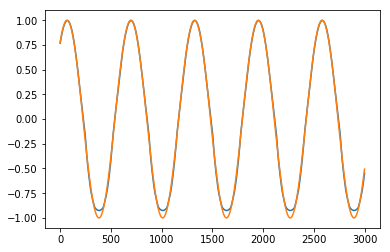

In [36]:
if __name__ == "__main__":
    main()